In [51]:
import numpy as np
import matplotlib.pyplot as plt

class MultiArmedBandit:
    def __init__(self, means, stds):
        self.n_arms = len(means)
        self.means = means
        self.stds = stds

    def pull(self, action):
        return np.random.normal(self.means[action], self.stds[action])

means = [1.0, 1.5, 2.0, 2.5, 3.0]
stds = [1.0] * 5
optimal_arm = int(np.argmax(means))
env = MultiArmedBandit(means, stds)


## 📊 Evaluation Function
Calculates cumulative reward, regret, optimal action %, and exploration efficiency.

In [52]:
def evaluate(results, optimal_arm, optimal_mean):
    actions = results["actions"]
    rewards = np.array(results["rewards"])
    steps = len(actions)

    cumulative_rewards = np.cumsum(rewards)
    regret = np.cumsum([optimal_mean - means[a] for a in actions])
    optimal_action_count = np.cumsum([1 if a == optimal_arm else 0 for a in actions])
    optimal_action_percentage = optimal_action_count / (np.arange(steps) + 1)

    exploration_efficiency = np.argmax(optimal_action_percentage >= 0.9) if np.any(optimal_action_percentage >= 0.9) else steps

    return cumulative_rewards, regret, optimal_action_percentage, exploration_efficiency


##II. Epsilon-Greedy (ε = 0.1)

In [54]:
def run_epsilon_greedy(env, steps=1000, epsilon=0.1):
    Q = np.zeros(env.n_arms)
    N = np.zeros(env.n_arms)
    actions, rewards = [], []

    for t in range(steps):
        if np.random.rand() < epsilon:
            action = np.random.randint(env.n_arms)
        else:
            action = np.argmax(Q)
        reward = env.pull(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        actions.append(action)
        rewards.append(reward)

    return {"actions": actions, "rewards": rewards}

eps_results = run_epsilon_greedy(env)
eps_metrics = evaluate(eps_results, optimal_arm, means[optimal_arm])


##III. UCB

In [55]:
def run_ucb(env, steps=1000, c=2):
    Q = np.zeros(env.n_arms)
    N = np.zeros(env.n_arms)
    actions, rewards = [], []

    for t in range(steps):
        if 0 in N:
            action = np.argmin(N)
        else:
            ucb = Q + c * np.sqrt(np.log(t+1) / N)
            action = np.argmax(ucb)
        reward = env.pull(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        actions.append(action)
        rewards.append(reward)

    return {"actions": actions, "rewards": rewards}

ucb_results = run_ucb(env)
ucb_metrics = evaluate(ucb_results, optimal_arm, means[optimal_arm])


##IV.Thompson Sampling

In [56]:
def run_thompson_sampling(env, steps=1000):
    alpha = np.ones(env.n_arms)
    beta = np.ones(env.n_arms)
    actions, rewards = [], []

    for t in range(steps):
        samples = np.random.beta(alpha, beta)
        action = np.argmax(samples)
        reward = env.pull(action)
        if reward >= 0:
            alpha[action] += reward
        else:
            beta[action] += -reward
        actions.append(action)
        rewards.append(reward)

    return {"actions": actions, "rewards": rewards}

ts_results = run_thompson_sampling(env)
ts_metrics = evaluate(ts_results, optimal_arm, means[optimal_arm])


##V.Policy Gradient

In [57]:
def run_policy_gradient(env, steps=1000, alpha=0.1):
    preferences = np.zeros(env.n_arms)
    actions, rewards = [], []

    for t in range(steps):
        probs = np.exp(preferences) / np.sum(np.exp(preferences))
        action = np.random.choice(env.n_arms, p=probs)
        reward = env.pull(action)
        baseline = np.mean(rewards) if rewards else 0
        for i in range(env.n_arms):
            if i == action:
                preferences[i] += alpha * (reward - baseline) * (1 - probs[i])
            else:
                preferences[i] -= alpha * (reward - baseline) * probs[i]
        actions.append(action)
        rewards.append(reward)

    return {"actions": actions, "rewards": rewards}

pg_results = run_policy_gradient(env)
pg_metrics = evaluate(pg_results, optimal_arm, means[optimal_arm])


## 📊 Run All Agents and Evaluate

In [59]:


def print_total_rewards(metrics_dict):
    for name, (cumulative_reward, _, _, _) in metrics_dict.items():
        print(f"{name:15}: Total Reward = {cumulative_reward[-1]:.2f}")

metrics_dict = {
    "Greedy": greedy_metrics,
    "Epsilon-Greedy": eps_metrics,
    "UCB": ucb_metrics,
    "Thompson Sampling": ts_metrics,
    "Policy Gradient": pg_metrics,
    "Decay Eps-Greedy": decay_metrics
}

print_total_rewards(metrics_dict)



Greedy         : Total Reward = 1027.64
Epsilon-Greedy : Total Reward = 2779.33
UCB            : Total Reward = 2912.20
Thompson Sampling: Total Reward = 2445.05
Policy Gradient: Total Reward = 2914.20
Decay Eps-Greedy: Total Reward = 2796.80


## 📈 Plot Metrics and Exploration Efficiency

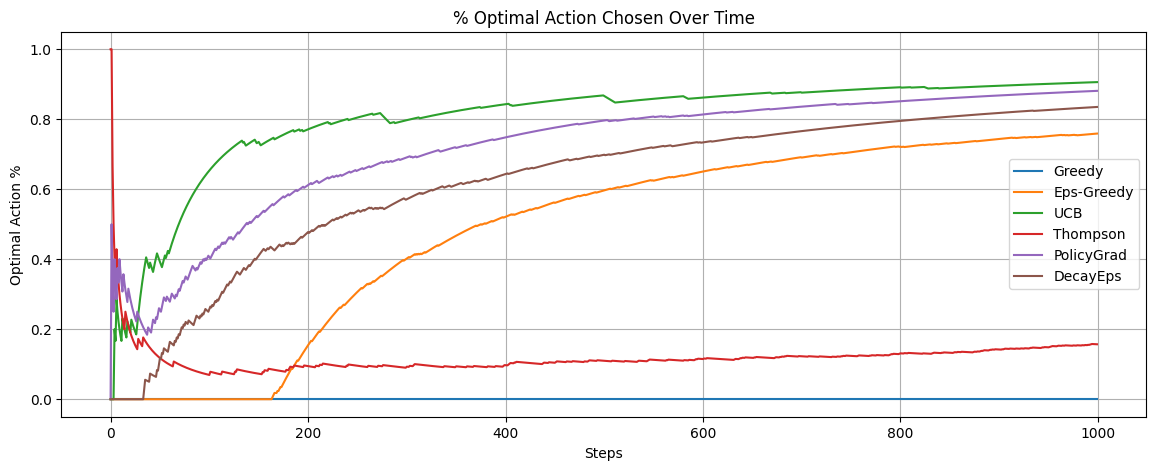

In [60]:
import matplotlib.pyplot as plt

algorithms = {
    "Greedy": greedy_metrics,
    "Eps-Greedy": eps_metrics,
    "UCB": ucb_metrics,
    "Thompson": ts_metrics,
    "PolicyGrad": pg_metrics,
    "DecayEps": decay_metrics
}

plt.figure(figsize=(14, 5))

for name, (reward, regret, opt_pct, _) in algorithms.items():
    plt.plot(opt_pct, label=name)

plt.title("% Optimal Action Chosen Over Time")
plt.xlabel("Steps")
plt.ylabel("Optimal Action %")
plt.legend()
plt.grid(True)
plt.show()


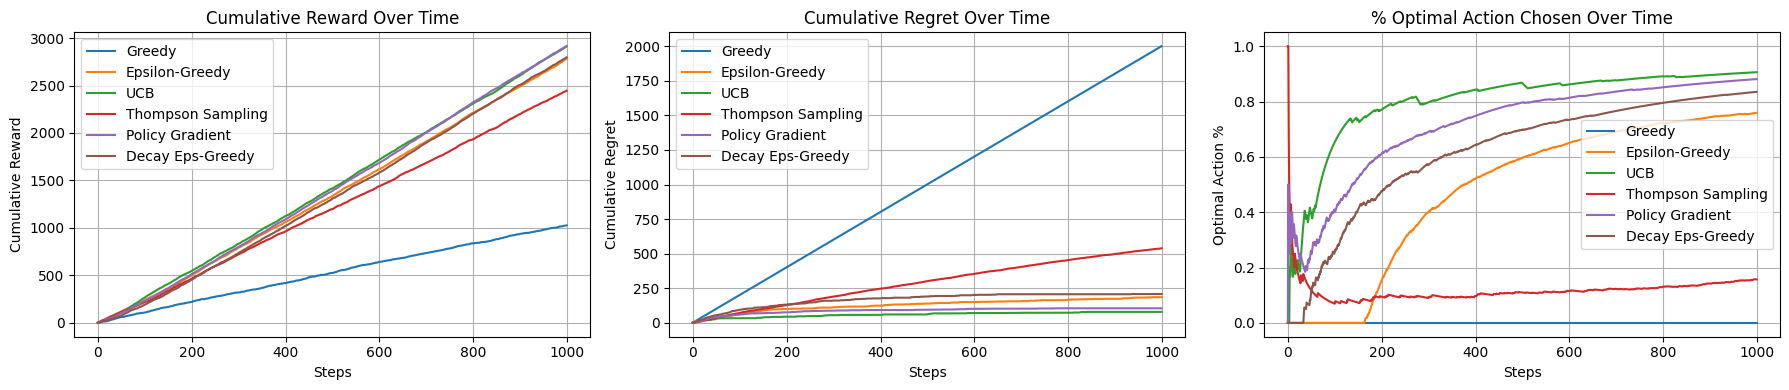

🧠 Exploration Efficiency (step when ≥90% optimal action chosen):

Greedy              : 1000 steps
Epsilon-Greedy      : 1000 steps
UCB                 : 939 steps
Thompson Sampling   : 0 steps
Policy Gradient     : 1000 steps
Decay Eps-Greedy    : 1000 steps


In [61]:
# Final Cell: Plot all metrics and print exploration efficiency

# Re-collect all metric results
metrics_dict = {
    "Greedy": greedy_metrics,
    "Epsilon-Greedy": eps_metrics,
    "UCB": ucb_metrics,
    "Thompson Sampling": ts_metrics,
    "Policy Gradient": pg_metrics,
    "Decay Eps-Greedy": decay_metrics
}

# Plot: Cumulative Reward
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
for name, (reward, _, _, _) in metrics_dict.items():
    plt.plot(reward, label=name)
plt.title("Cumulative Reward Over Time")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)

# Plot: Cumulative Regret
plt.subplot(1, 3, 2)
for name, (_, regret, _, _) in metrics_dict.items():
    plt.plot(regret, label=name)
plt.title("Cumulative Regret Over Time")
plt.xlabel("Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.grid(True)

# Plot: Optimal Action Percentage
plt.subplot(1, 3, 3)
for name, (_, _, opt_pct, _) in metrics_dict.items():
    plt.plot(opt_pct, label=name)
plt.title("% Optimal Action Chosen Over Time")
plt.xlabel("Steps")
plt.ylabel("Optimal Action %")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print Exploration Efficiency
print("🧠 Exploration Efficiency (step when ≥90% optimal action chosen):\n")
for name, (_, _, _, eff) in metrics_dict.items():
    print(f"{name:20}: {eff} steps")
